Refrensi :
- https://www.kaggle.com/code/brsdincer/mask-prediction-process-end-to-end#PATH-AND-LABEL-PROCESS
- https://www.kaggle.com/datasets/vijaykumar1799/face-mask-detection/data

# Set-up Env Variable kaggle config & Download Data

In [1]:
# # Set-up Env Variable for kaggle Config
# import os
# os.environ['KAGGLE_CONFIG_DIR'] = '/content/drive/MyDrive/Colab Notebooks/1. BISA AI - [Studi Independen]/Computer Vision - Open CV/Final Project [Enrollment Deteksi Object YOLO]/'

# # Download and Unzip the dataset
# # Dengan cara ***Pilih Dataset*** di ***Kaggle***, lalu klik ***Titik Tiga***, dan pilih ***Copy API Command***

# # Tentukan path untuk menyimpan dataset
# path_to_save = '/content/drive/MyDrive/Colab Notebooks/1. BISA AI - [Studi Independen]/Computer Vision - Open CV/Final Project [Enrollment Deteksi Object YOLO]/Dataset/'

# # Buat direktori jika belum ada
# os.makedirs(path_to_save, exist_ok=True)

# # Unduh dataset menggunakan perintah kaggle
# !kaggle datasets download -d vijaykumar1799/face-mask-detection -p '{path_to_save}'

In [2]:
# # Ekstrak dataset
# !unzip '{path_to_save}/face-mask-detection.zip' -d '{path_to_save}'

# # Hapus file zip jika diperlukan
# os.remove(f'{path_to_save}/face-mask-detection.zip')

# Library Needed

In [3]:
!pip install mxnet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.1/49.1 MB 20.2 MB/s eta 0:00:00
  Attempting uninstall: graphviz
    Found existing installation: graphviz 0.20.3
    Uninstalling graphviz-0.20.3:
      Successfully uninstalled graphviz-0.20.3


In [46]:
#GENERAL
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import random
import time

#PATH PROCESS
import os
import glob
from pathlib import Path

#IMAGE PROCESS
from PIL import Image
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import cv2
from keras.applications.vgg16 import preprocess_input, decode_predictions

#SCALER & TRANSFORMATION
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical

#ACCURACY CONTROL
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, roc_auc_score, roc_curve
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score

#OPTIMIZER
from keras.optimizers import RMSprop, Adam, SGD

#MODEL LAYERS
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization, \
                                    MaxPooling2D, GlobalAveragePooling2D, SeparableConv2D, ZeroPadding2D, \
                                    Convolution2D, ZeroPadding2D, LSTM, SimpleRNN, GRU, Bidirectional, Permute, \
                                    TimeDistributed
from tensorflow.keras.applications import VGG16, VGG19, InceptionV3
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras import models
from keras import layers
import tensorflow as tf
from keras.utils import plot_model

#IGNORING WARNINGS
import warnings
warnings.filterwarnings("ignore")

#PLOT TYPE
plt.style.use("classic")

# Read Dataset

## Data Path

In [5]:
mainPath = "/content/drive/MyDrive/Colab Notebooks/1. BISA AI - [Studi Independen]/Computer Vision - Open CV/Final Project [Enrollment Deep Learning dengan Tensorflow]/"

In [6]:
Data_Path = Path("/content/drive/MyDrive/Colab Notebooks/1. BISA AI - [Studi Independen]/Computer Vision - Open CV/Final Project [Enrollment Deep Learning dengan Tensorflow]/Dataset")

In [7]:
# Membuat daftar semua file PNG di dalam direktori Data_Path beserta subdirektorinya
PNG_Path = list(Data_Path.glob(r"*/*.png"))

## Label

In [8]:
PNG_Labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1],PNG_Path))

In [9]:
# os.path.split(os.path.split(PNG_Path[0])[0])[1]

## To Series

In [10]:
PNG_Path_Series = pd.Series(PNG_Path,name="PNG").astype(str)

In [11]:
PNG_Labels_Series = pd.Series(PNG_Labels,name="CATEGORY")

## To Dataframe

In [12]:
Main_Data = pd.concat([PNG_Path_Series, PNG_Labels_Series],axis=1)

In [13]:
Main_Data["CATEGORY"].value_counts()

CATEGORY
mask_weared_incorrect    2994
with_mask                2994
without_mask             2994
Name: count, dtype: int64

## Shuffle Data

In [14]:
Main_Data = Main_Data.sample(frac=1).reset_index(drop=True)
# jika frac=1, itu berarti mengambil seluruh data.
# Sedangkan jika frac=0.5, itu berarti mengambil setengah data secara acak.

# Visualization

In [15]:
def general_showing(integer_of_image):

    Example_PNG = Main_Data["PNG"][integer_of_image] # Indexing the dataframe and get the path of image
    Reading_IMG = cv2.imread(Example_PNG) # Read Image
    Transformation_RGB = cv2.cvtColor(Reading_IMG,cv2.COLOR_BGR2RGB) #

    plt.xlabel(Transformation_RGB.shape)
    plt.ylabel(Transformation_RGB.size)
    plt.title(Main_Data["CATEGORY"][integer_of_image])

    return plt.imshow(Transformation_RGB)

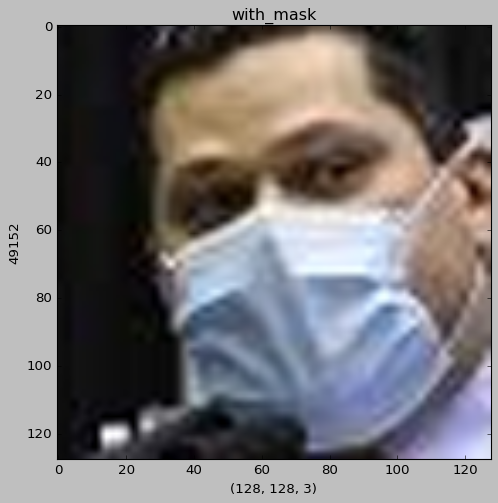

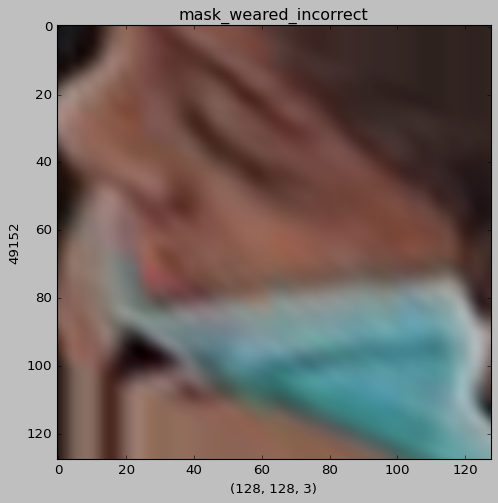

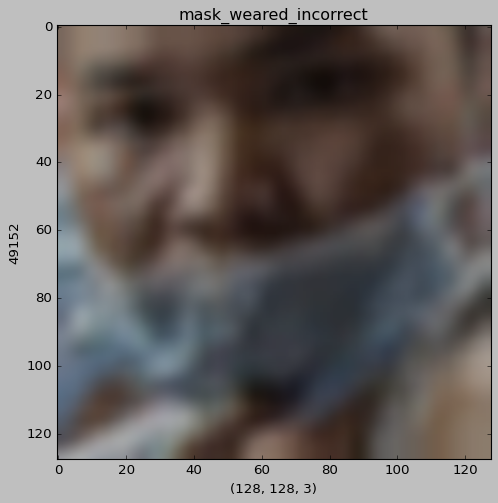

In [16]:
figure = plt.figure(figsize=(7,7))
general_showing(5909)

figure = plt.figure(figsize=(7,7))
general_showing(3)

figure = plt.figure(figsize=(7,7))
general_showing(8980)

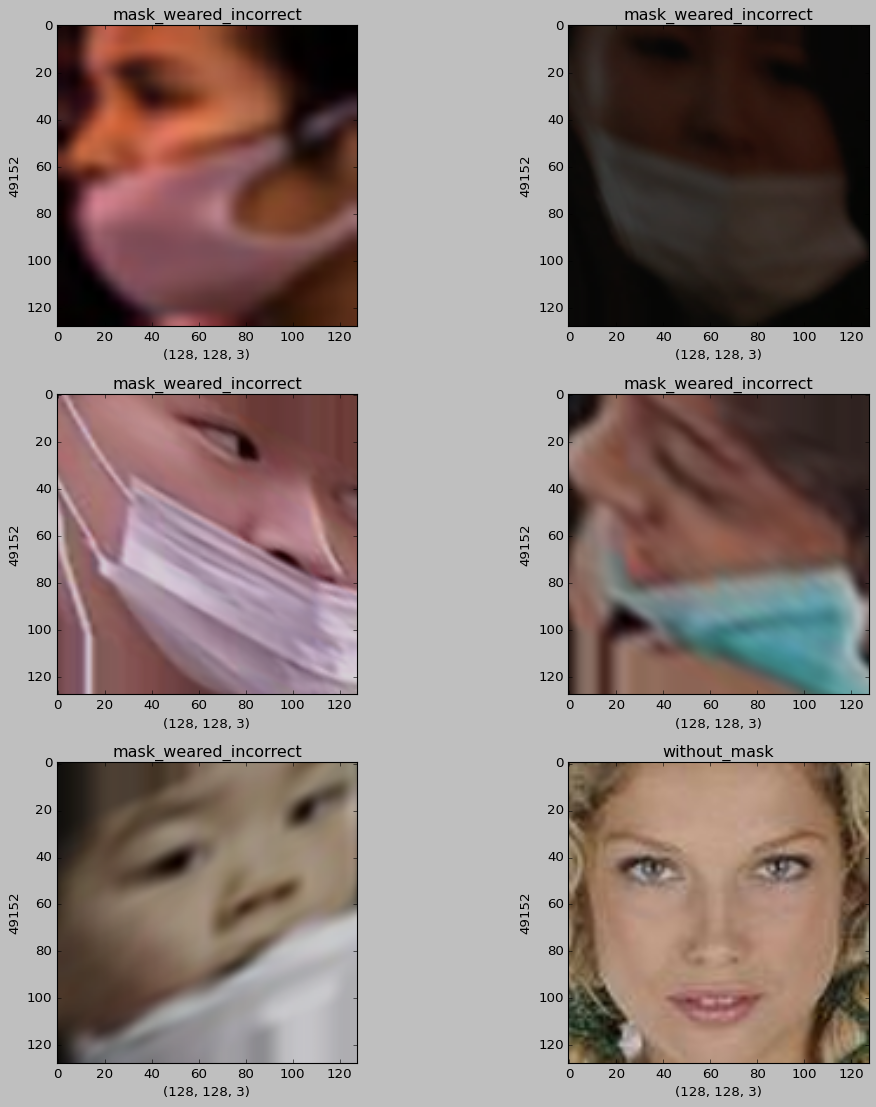

In [17]:
figure,axis = plt.subplots(nrows=3,ncols=2,figsize=(14,14))

for indexing,run_axes in enumerate(axis.flat):
    Reading_IMG = cv2.imread(Main_Data["PNG"][indexing])
    Transformation_IMG = cv2.cvtColor(Reading_IMG,cv2.COLOR_BGR2RGB)

    run_axes.set_xlabel(Transformation_IMG.shape)
    run_axes.set_ylabel(Transformation_IMG.size)
    run_axes.set_title(Main_Data["CATEGORY"][indexing])

    run_axes.imshow(Transformation_IMG)

plt.tight_layout()
plt.show()

# Splitting Test and Train Data

In [18]:
Train_Data, Test_Data = train_test_split(Main_Data, train_size=0.8, shuffle=True, random_state=42)

In [19]:
display(Train_Data.shape)
display(Test_Data.shape)

(7185, 2)

(1797, 2)

# Image Generator

## Structure

In [20]:
Train_IMG_Generator = ImageDataGenerator(rescale=1./255,
                                        rotation_range=25,
                                        shear_range=0.5,
                                        zoom_range=0.5,
                                        width_shift_range=0.2,
                                        height_shift_range=0.2,
                                        horizontal_flip=True,
                                        fill_mode="nearest",
                                        validation_split=0.1)

In [21]:
Test_IMG_Generator = ImageDataGenerator(rescale=1./255)

## Apply

In [22]:
Train_IMG_Set = Train_IMG_Generator.flow_from_dataframe(dataframe=Train_Data,
                                                       x_col="PNG",
                                                       y_col="CATEGORY",
                                                       color_mode="rgb",
                                                       class_mode="categorical",
                                                       target_size=(128,128),
                                                       subset="training")

Found 6467 validated image filenames belonging to 3 classes.


In [23]:
Validation_IMG_Set = Train_IMG_Generator.flow_from_dataframe(dataframe=Train_Data,
                                                       x_col="PNG",
                                                       y_col="CATEGORY",
                                                       color_mode="rgb",
                                                       class_mode="categorical",
                                                       target_size=(128,128),
                                                       subset="validation")

Found 718 validated image filenames belonging to 3 classes.


In [24]:
Test_IMG_Set = Test_IMG_Generator.flow_from_dataframe(dataframe=Test_Data,
                                                       x_col="PNG",
                                                       y_col="CATEGORY",
                                                       color_mode="rgb",
                                                       class_mode="categorical",
                                                       target_size=(128,128),
                                                       shuffle=False)

Found 1797 validated image filenames belonging to 3 classes.


In [25]:
print("TRAIN: ")
print(Train_IMG_Set.class_indices)
print(Train_IMG_Set.classes[0:5])
print(Train_IMG_Set.image_shape)
print("---"*20)
print("VALIDATION: ")
print(Validation_IMG_Set.class_indices)
print(Validation_IMG_Set.classes[0:5])
print(Validation_IMG_Set.image_shape)
print("---"*20)
print("TEST: ")
print(Test_IMG_Set.class_indices)
print(Test_IMG_Set.classes[0:5])
print(Test_IMG_Set.image_shape)

TRAIN: 
{'mask_weared_incorrect': 0, 'with_mask': 1, 'without_mask': 2}
[2, 2, 0, 0, 0]
(128, 128, 3)
------------------------------------------------------------
VALIDATION: 
{'mask_weared_incorrect': 0, 'with_mask': 1, 'without_mask': 2}
[2, 1, 2, 1, 2]
(128, 128, 3)
------------------------------------------------------------
TEST: 
{'mask_weared_incorrect': 0, 'with_mask': 1, 'without_mask': 2}
[0, 0, 1, 1, 1]
(128, 128, 3)


## How to Look by Generator

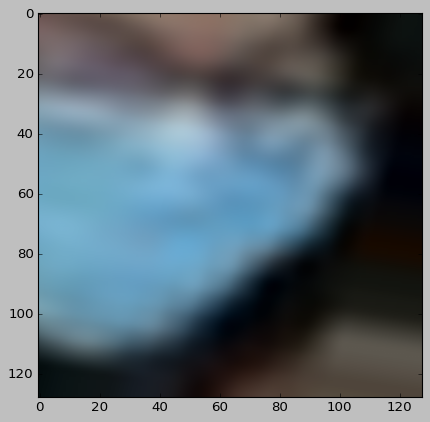

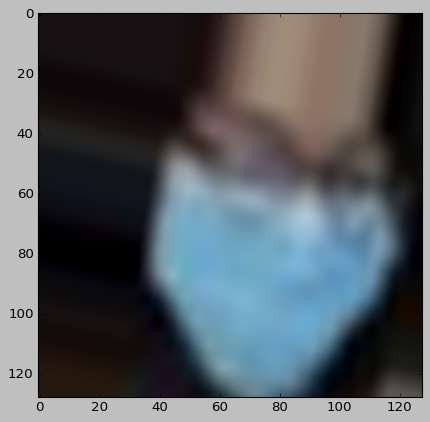

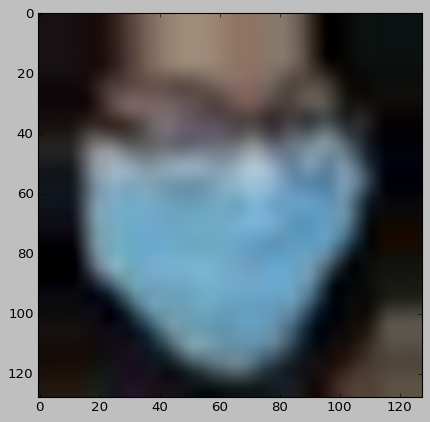

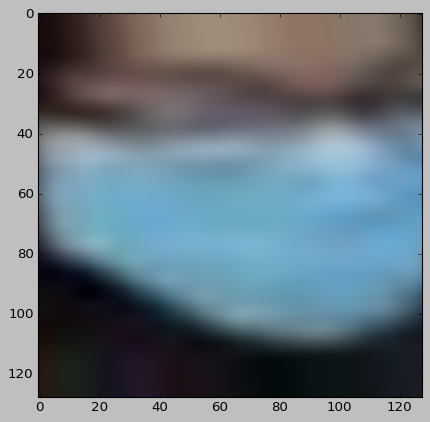

In [26]:
Example_Image = Train_Data["PNG"][422]
Reading_Image = cv2.imread(Example_Image)
Transformation_Image = cv2.cvtColor(Reading_Image,cv2.COLOR_BGR2RGB)
Array_Image = image.img_to_array(Transformation_Image)
Array_Image = Array_Image.reshape((1,)+Array_Image.shape)

i = 0

for batch in Train_IMG_Generator.flow(Array_Image,batch_size=32):
    plt.figure(i)

    Image = plt.imshow(image.img_to_array(batch[0]))

    i += 1

    if i % 4 == 0:
        break

plt.show()

# Modeling

In [27]:
Model = Sequential()

# Convolutional Layer 1
Model.add(Conv2D(32, (3, 3), activation="relu", input_shape=(128, 128, 3)))
Model.add(BatchNormalization())
Model.add(MaxPooling2D((2, 2)))

# Convolutional Layer 2
Model.add(Conv2D(64, (3, 3), padding="same", activation="relu"))
Model.add(Dropout(0.3))
Model.add(MaxPooling2D((2, 2)))

# Convolutional Layer 3
Model.add(Conv2D(128, (3, 3), padding="same", activation="relu"))
Model.add(Dropout(0.3))
Model.add(MaxPooling2D((2, 2)))

# Convolutional Layer 4
Model.add(Conv2D(128, (3, 3), padding="same", activation="relu"))
Model.add(Dropout(0.3))
Model.add(MaxPooling2D((2, 2)))

# Flatten Layer
Model.add(Flatten())
Model.add(Dense(256, activation="relu"))
Model.add(Dropout(0.5))

# Output Layer
Model.add(Dense(3, activation="softmax"))

In [28]:
#Penggunaan Callback untuk menghentikan proses training sesuai akurasi yang diinginkan

class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        val_accuracy = logs.get('val_accuracy')
        accuracy = logs.get('accuracy')

        if val_accuracy is not None and accuracy is not None:
            if val_accuracy > 0.95 and accuracy > 0.95:
                print("\nSudah >95% nih akurasinya jadi diberhentikan saja!")
                self.model.stop_training = True
            else:
                print("\nBelum mencapai akurasi >95%, lanjutkan training.")
        else:
            print("\nNilai akurasi tidak tersedia. Lanjutkan training.")


callbacks = myCallback()

In [29]:
# Tentukan kondisi EarlyStopping
early_stopping = EarlyStopping(
    monitor='val_accuracy',  # Monitor akurasi pada data validasi
    patience=4,  # Toleransi untuk tidak ada peningkatan
    restore_best_weights=True,  # Kembalikan bobot terbaik ketika berhenti
    verbose=1,
    mode="min"
)


# Reduce learning rate on plateau
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

# Callbacks list
callbacks_list = [early_stopping, callbacks, reduce_lr]

In [30]:
Model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

In [31]:
Model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 32)      896       
                                                                 
 batch_normalization (Batch  (None, 126, 126, 32)      128       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 63, 63, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 63, 63, 64)        18496     
                                                                 
 dropout (Dropout)           (None, 63, 63, 64)        0         
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 31, 31, 64)        0

In [32]:
start_time = time.time()

CNN_Sep_Model = Model.fit(Train_IMG_Set, validation_data=Validation_IMG_Set, callbacks=callbacks_list, epochs=50)

end_time = time.time()

duration = end_time - start_time
print("Duration:", duration, "seconds")

Epoch 1/50
203/203 [==============================] - ETA: 0s - loss: 0.6094 - accuracy: 0.7781
Belum mencapai akurasi >95%, lanjutkan training.
203/203 [==============================] - 2202s 11s/step - loss: 0.6094 - accuracy: 0.7781 - val_loss: 0.8951 - val_accuracy: 0.7089 - lr: 0.0010
Epoch 2/50
203/203 [==============================] - ETA: 0s - loss: 0.4816 - accuracy: 0.8143
Belum mencapai akurasi >95%, lanjutkan training.
203/203 [==============================] - 66s 323ms/step - loss: 0.4816 - accuracy: 0.8143 - val_loss: 0.7912 - val_accuracy: 0.7786 - lr: 0.0010
Epoch 3/50
203/203 [==============================] - ETA: 0s - loss: 0.4210 - accuracy: 0.8415
Belum mencapai akurasi >95%, lanjutkan training.
203/203 [==============================] - 61s 298ms/step - loss: 0.4210 - accuracy: 0.8415 - val_loss: 0.6661 - val_accuracy: 0.8245 - lr: 0.0010
Epoch 4/50
203/203 [==============================] - ETA: 0s - loss: 0.3630 - accuracy: 0.8693
Belum mencapai akurasi >95%,

<Axes: >

<Figure size 800x800 with 0 Axes>

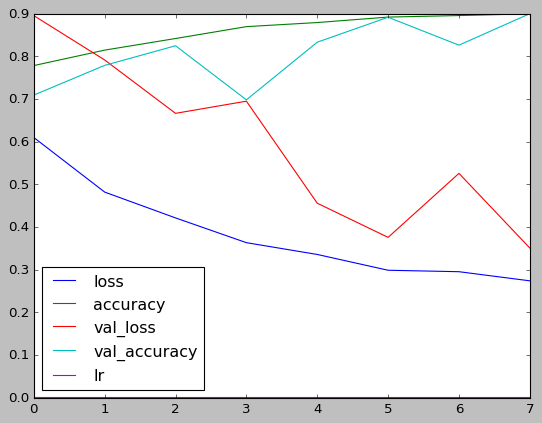

In [33]:
Grap_Data = pd.DataFrame(CNN_Sep_Model.history)
figure = plt.figure(figsize=(10,10))

Grap_Data.plot()

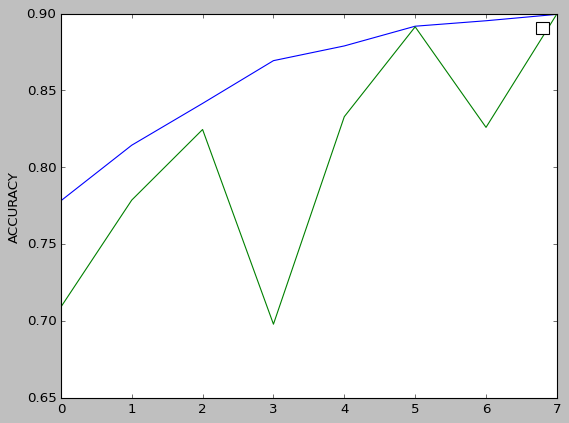

In [34]:
plt.plot(CNN_Sep_Model.history["accuracy"])
plt.plot(CNN_Sep_Model.history["val_accuracy"])
plt.ylabel("ACCURACY")
plt.legend()
plt.show()

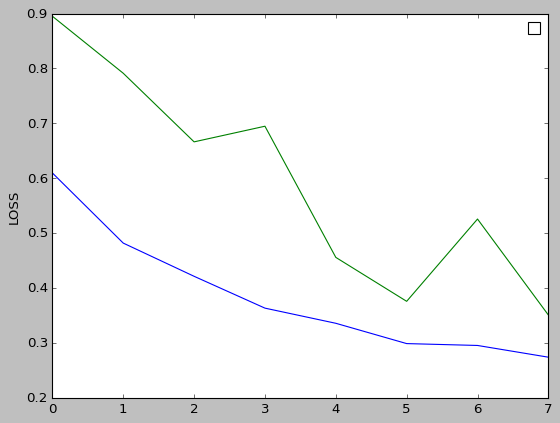

In [35]:
plt.plot(CNN_Sep_Model.history["loss"])
plt.plot(CNN_Sep_Model.history["val_loss"])
plt.ylabel("LOSS")
plt.legend()
plt.show()

## Saving Model

In [42]:
mainPath = "/content/drive/MyDrive/Colab Notebooks/1. BISA AI - [Studi Independen]/Computer Vision - Open CV/Final Project [Enrollment Deep Learning dengan Tensorflow]/"

Model.save(mainPath + "Face_Mask_Detection.h5")
Model.save_weights(mainPath + "Weight_Face_Mask_Detection.h5")

## Prediction

In [37]:
Model_Results = Model.evaluate(Test_IMG_Set)
print("LOSS:  " + "%.4f" % Model_Results[0])
print("ACCURACY:  " + "%.4f" % Model_Results[1])

57/57 [==============================] - 520s 9s/step - loss: 0.5398 - accuracy: 0.7902
LOSS:  0.5398
ACCURACY:  0.7902


In [38]:
Prediction_Number = Model.predict(Test_IMG_Set)
Prediction_Number[0:10]

57/57 [==============================] - 8s 130ms/step


array([[0.8201866 , 0.10022694, 0.07958643],
       [0.9596978 , 0.03342858, 0.00687363],
       [0.7184372 , 0.27338883, 0.00817402],
       [0.5907532 , 0.29819474, 0.11105207],
       [0.42425382, 0.5257616 , 0.04998459],
       [0.19605471, 0.10653611, 0.6974092 ],
       [0.5147397 , 0.14439291, 0.3408674 ],
       [0.30499554, 0.6775275 , 0.01747699],
       [0.9277889 , 0.0474038 , 0.02480726],
       [0.9647669 , 0.02686096, 0.00837214]], dtype=float32)

In [39]:
Prediction = Prediction_Number.argmax(axis=-1)

In [40]:
Prediction[0:10]

array([0, 0, 0, 0, 1, 2, 0, 1, 0, 0])

# Final Predict Result

In [41]:
fig, axes = plt.subplots(nrows=5,
                         ncols=5,
                         figsize=(20, 20),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(Test_Data["PNG"].iloc[i]))
    ax.set_title(f"PREDICTION:{Prediction[i]}")
    ax.set_xlabel(Test_Data["CATEGORY"].iloc[i])
plt.tight_layout()
plt.show()

Output hidden; open in https://colab.research.google.com to view.

## Load Model

In [41]:
CNN_Main_Model = load_model(mainPath + "Face_Mask_Detection.h5")

### Try to [No Mask] Image

In [43]:
Non_Seen_Image = mainPath + "NonSeen Data/me_without_mask.jpg"

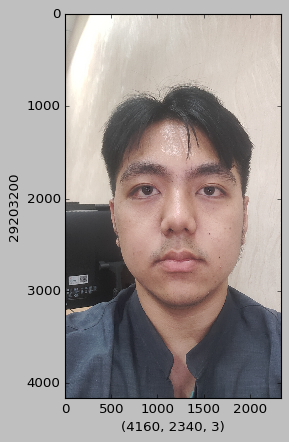

In [44]:
Reading_IMG = cv2.imread(Non_Seen_Image)
Transformation_RGB = cv2.cvtColor(Reading_IMG,cv2.COLOR_BGR2RGB)

plt.xlabel(Transformation_RGB.shape)
plt.ylabel(Transformation_RGB.size)

plt.imshow(Transformation_RGB)

In [47]:
img = load_img(Non_Seen_Image, target_size=(128, 128))  # Loading image
img = image.img_to_array(img)  # Transforming image to array
img = img / 255  # Normalizing Image
img = np.expand_dims(img, axis=0)

print(img.shape)

(1, 128, 128, 3)


In [48]:
Non_Seen_Predict = Model.predict(img)

1/1 [==============================] - 0s 421ms/step


In [49]:
Non_Seen_Predict = Non_Seen_Predict.argmax(axis=-1)
print(Non_Seen_Predict)

[2]


In [50]:
Test_IMG_Set.class_indices

{'mask_weared_incorrect': 0, 'with_mask': 1, 'without_mask': 2}